In [5]:
from pykalman import KalmanFilter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import poly1d
import datetime as dt
import yfinance as yf
import pandas_datareader.data as reader

In [28]:
end= dt.datetime.now()
start=dt.date(end.year-5, end.month, end.day)
Input=['MSFT']

In [29]:
#get data
df = reader.get_data_yahoo(Input, start, end)['Adj Close']

In [30]:
df.head()

Symbols,MSFT
Date,
2015-12-28,51.056156
2015-12-29,51.603676
2015-12-30,51.384666
2015-12-31,50.627274
2016-01-04,50.006744


In [9]:
# Kalman Filter, updates its estimates at every time step to weigh recent observations more than older ones. We
# assume the observation have variance 1 around the rolling mean, the initial guess of the mean is 0 but the filter
# quickly adjusts
kf = KalmanFilter(transition_matrices=[1],
                 observation_matrices=[1],
                 initial_state_mean=0,
                 initial_state_covariance=1,
                 observation_covariance=1,
                 transition_covariance=0.01)

In [31]:
# Use observed values to get the rolling mean
state_means, _ = kf.filter(df.values)

In [32]:
# Compute the rolling mean for 30, 60 and 90 lookback windows
mean30 = df.rolling(30).mean()
mean60 = df.rolling(60).mean()
mean90 = df.rolling(90).mean()

Text(0, 0.5, 'Price')

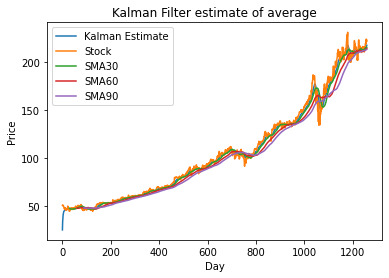

In [37]:
# Plot original data and estimated mean
#%matplotlib qt
%matplotlib inline 
plt.plot(state_means)
plt.plot(df.values)
plt.plot(mean30.values)
plt.plot(mean60.values)
plt.plot(mean90.values)
plt.title('Kalman Filter estimate of average')
plt.legend(['Kalman Estimate', 'Stock', 'SMA30', 'SMA60', 'SMA90'])
plt.xlabel('Day')
plt.ylabel('Price')

The advantage is that we don't need to chose a window length. Less risk of overfitting

### Example on linear regression

Using Kalman Filter to calculate the linear regression model of a stock price and the S&P500. The result should be a rolling alpha and beta for the stock. $$y_t=\alpha+\beta x_t $$

In [54]:
# get data
end= '2015-01-01'
start='2012-01-01'
Input=['AMZN', '^GSPC']

In [55]:
df = reader.get_data_yahoo(Input, start, end)['Adj Close']

In [56]:
df.head()

Symbols,AMZN,^GSPC
Date,,
2012-01-03,179.029999,1277.060059
2012-01-04,177.509995,1277.300049
2012-01-05,177.610001,1281.060059
2012-01-06,182.610001,1277.810059
2012-01-09,178.559998,1280.699951


In [57]:
y = df['AMZN']
x = df['^GSPC']

Text(0, 0.5, 'AMZN')

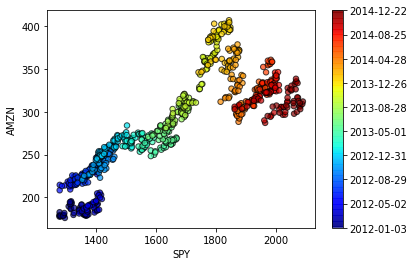

In [58]:
# plot data and use colormap to inidcate the date each point corresponds to
cm = plt.get_cmap('jet')
colors = np.linspace(0.1, 1, len(x))
sc = plt.scatter(x, y, s=30, c=colors, cmap=cm, edgecolor='k', alpha=0.7)
cb=plt.colorbar(sc)
cb.ax.set_yticklabels([str(p.date())for p in x[::len(x)//9].index])
plt.xlabel('SPY')
plt.ylabel('AMZN')

The state of our system is the line following with parameters $\alpha$ and $\beta$. Our initial guess for these parameters is (0, 0) with a covariance matrix of all ones. To get from the state to an observation we take the dot product of ($\beta$, $\alpha$) and ($x_i,1$) to get $\beta x_i + \alpha = y_i$ so the observation matrix is just a column of 1s. We assume that the variance of our observations y is 2.

In [59]:
delta = 1e-3
trans_cov = delta/(1-delta)*np.eye(2) # random walk, how much wiggle
obs_mat = np.expand_dims(np.vstack([[x], [np.ones(len(x))]]).T, axis=1)

kf = KalmanFilter(n_dim_obs=1, n_dim_state=2,#y is 1 dim, (alpha, beta) is 2 dim
                 initial_state_mean=[0,0],
                 initial_state_covariance=np.ones((2,2)),
                 transition_matrices=np.eye(2),
                 observation_matrices=obs_mat,
                 observation_covariance=2,
                 transition_covariance=trans_cov)

In [60]:
#use the observation y to get running estimates and errors for the state parameters
state_means, state_covs = kf.filter(y.values)

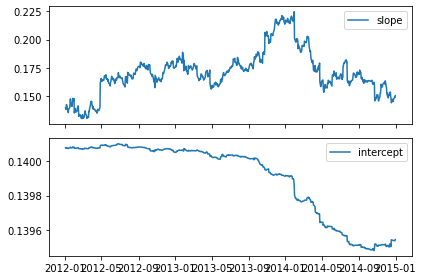

In [61]:
#Plot best estimate mean of alpha and beta
_,axarr=plt.subplots(2, sharex=True)
axarr[0].plot(x.index, state_means[:,0], label='slope')
axarr[0].legend()
axarr[1].plot(x.index, state_means[:,1], label='intercept')
axarr[1].legend()
plt.tight_layout();

Notice how much the parameters are fluctuating over time. If we are using a trading algorithm on this, like beta hedging, it's important to have an acurate and most current estimate of the beta. To visualize how the system evolves over time, we plot every fifth state below.

Text(0, 0.5, 'AMZN')

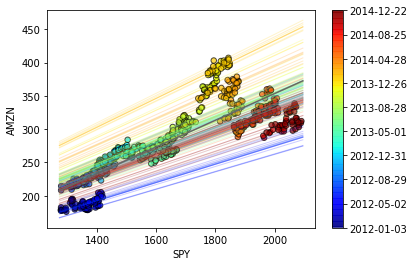

In [96]:
# Plot data points using colormap
sc = plt.scatter(x, y, s=30, c=colors, cmap=cm, edgecolor='k', alpha=0.7)
cb = plt.colorbar(sc)
cb.ax.set_yticklabels([str(p.date()) for p in x[::len(x)//9].index])

# plot every fifth line
step=5
xi=np.linspace(x.min()-5, x.max()+5, 2)
colors_l=np.linspace(0.1, 1, len(state_means[::step]))

for i, beta in enumerate(state_means[::step]):
    plt.plot(xi, beta[0]*xi + beta[1], alpha=.2, lw=1, c=cm(colors_l[i]))    
    
    

# Plot OLS regression line
plt.plot(xi, poly1d(np.polyfit(x,y,1))(xi), '0.4')

plt.xlabel('SPY')
plt.ylabel('AMZN')

Notice even considering all previous observations, the state estimates fit the more recent data better than the older. 

### Linear regression on returns

In [105]:
# calculate returns from price data
x_r = x.pct_change()[1:]
y_r = y.pct_change()[1:]

In [136]:
x_r

Date
2012-01-04    0.000188
2012-01-05    0.002944
2012-01-06   -0.002537
2012-01-09    0.002262
2012-01-10    0.008886
                ...   
2014-12-24   -0.000139
2014-12-26    0.003310
2014-12-29    0.000862
2014-12-30   -0.004889
2014-12-31   -0.010311
Name: ^GSPC, Length: 753, dtype: float64

In [137]:
# Run Kalman on returns data
delta_r = 1e-2
trans_cov_r = delta_r/(1-delta_r)*np.eye(2) # random walk, how much wiggle
obs_mat_r = np.expand_dims(np.vstack([[x_r], [np.ones(len(x_r))]]).T, axis=1)

kf_r = KalmanFilter(n_dim_obs=1, n_dim_state=2,#y is 1 dim, (alpha, beta) is 2 dim
                 initial_state_mean=[0,0],
                 initial_state_covariance=np.ones((2,2)),
                 transition_matrices=np.eye(2),
                 observation_matrices=obs_mat_r,
                 observation_covariance=0.01,
                 transition_covariance=trans_cov_r)

In [138]:
state_mean_r, _ = kf_r.filter(y_r.values)

Text(0, 0.5, 'AMZN')

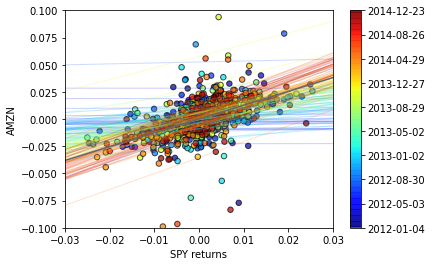

In [140]:
# plot data using color map
color_r = np.linspace(0.1,1,len(x_r))
sc = plt.scatter(x_r, y_r, s=30, c=color_r, cmap=cm, edgecolor='k', alpha=0.7)
cb = plt.colorbar(sc)
cb.ax.set_yticklabels([str(p.date()) for p in x_r[::len(x_r)//9].index])

#plot every 5th line
step=5
xi=np.linspace(x_r.min()-4, x_r.max()+4, 2)
colors_l=np.linspace(0.1,1, len(state_mean_r[::step]))
for i, beta in enumerate(state_mean_r[::step]):
    plt.plot(xi, beta[0]*xi+beta[1], alpha=.2,lw=1, c=cm(colors_l[i]))
    
# plot the OLS regression line
plt.plot(xi, poly1d(np.polyfit(x_r, y_r, 1))(xi), '0.4')
plt.axis([-0.03,0.03,-0.10,0.10])

plt.xlabel('SPY returns')
plt.ylabel('AMZN')